In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =6.375563e-24

nband = 80

ng =9

ng_adju = (/ 2 , 2 /) 

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.65 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

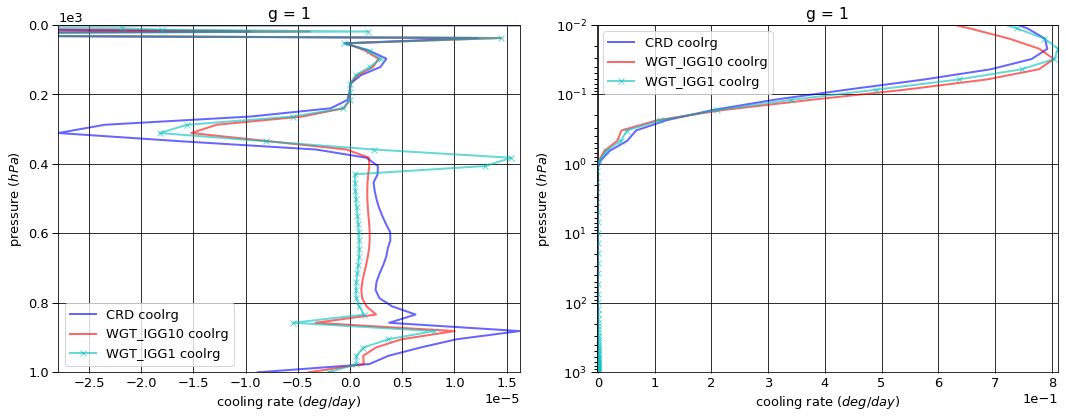

# Figure: cooling rate g-group 2

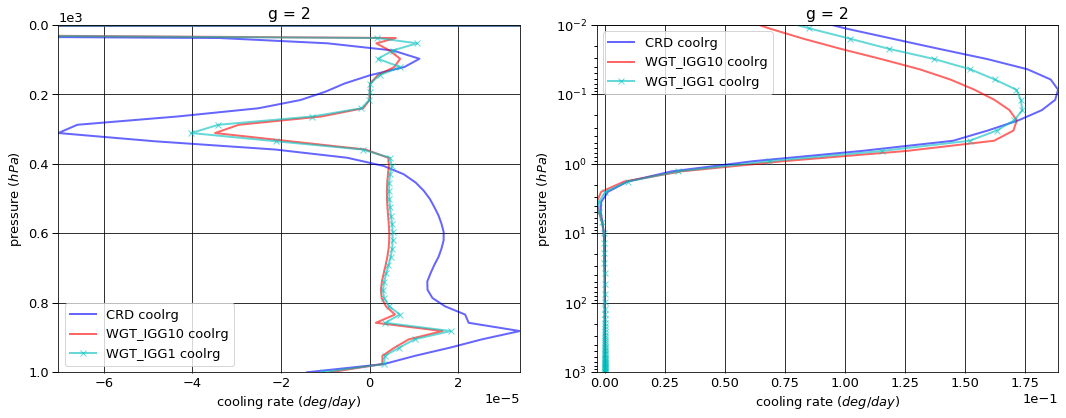

# Figure: cooling rate g-group 3

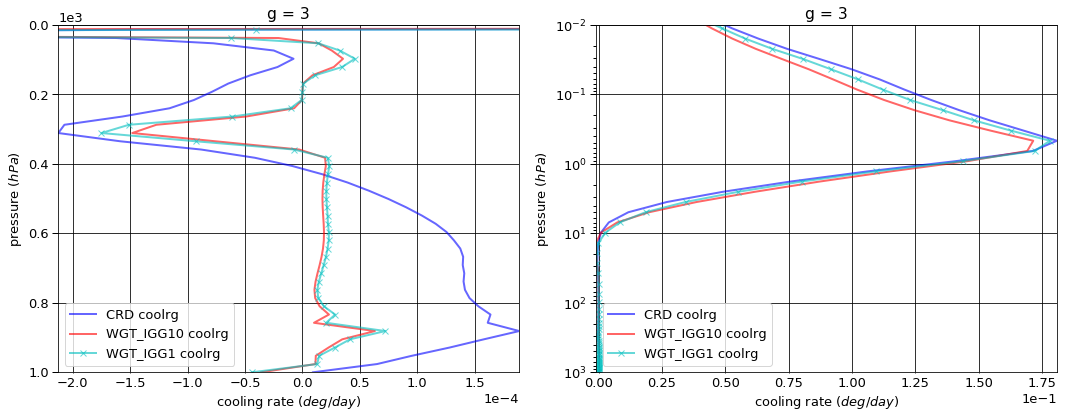

# Figure: cooling rate g-group 4

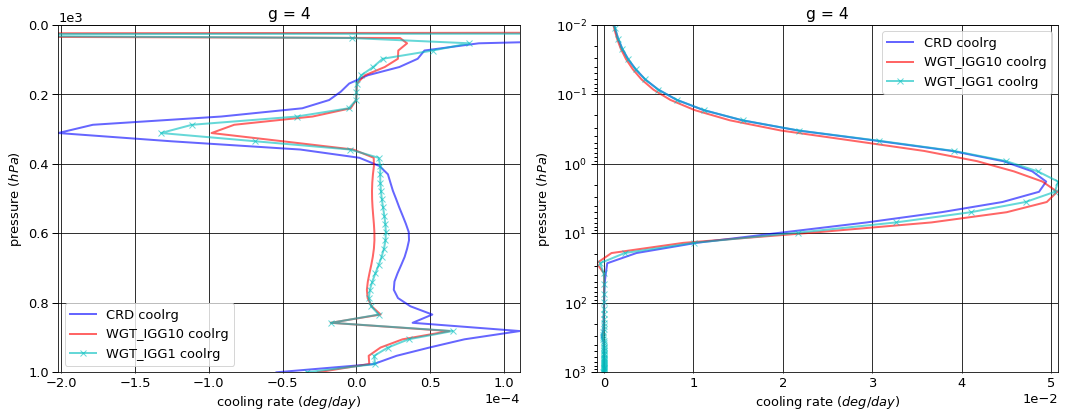

# Figure: cooling rate g-group 5

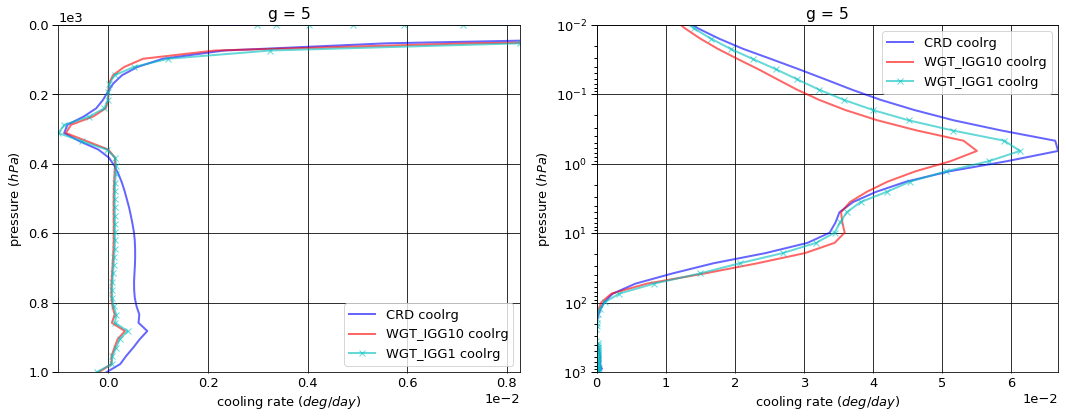

# Figure: cooling rate g-group 6

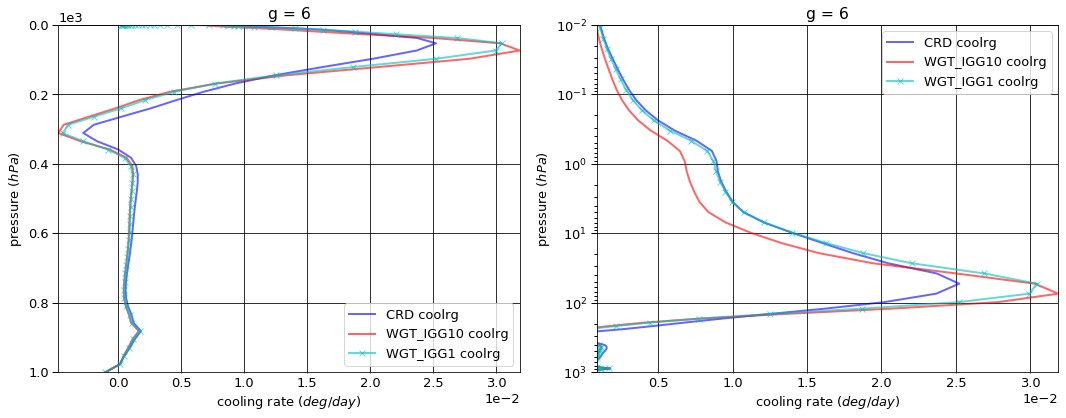

# Figure: cooling rate g-group 7

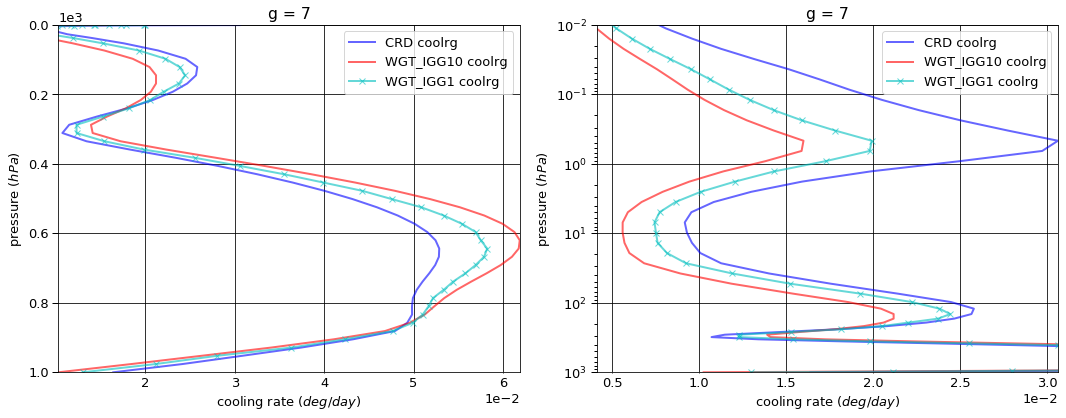

# Figure: cooling rate g-group 8

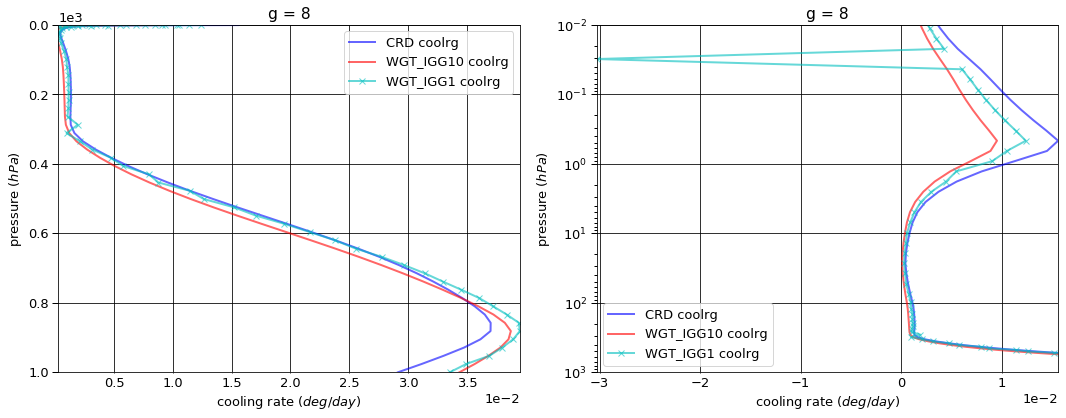

# Figure: cooling rate g-group 9

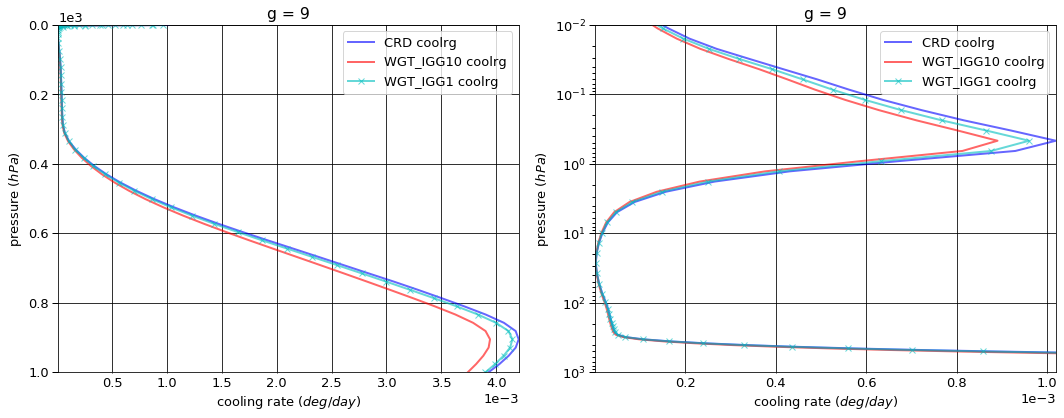

# Figure: cooling rate g-group total

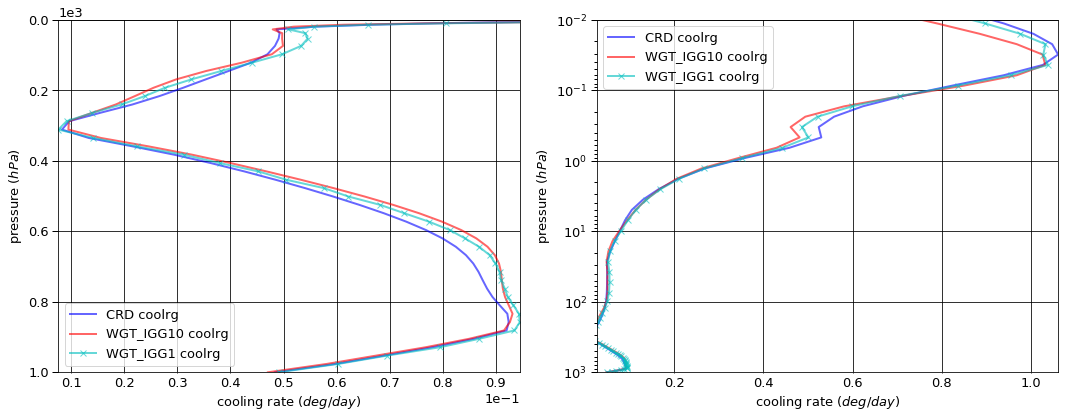

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012968  0.000000 -0.012968
  1013.0   76    -0.015269  0.015307  0.000038
2 0.0      1     -0.016268  0.000000 -0.016268
  1013.0   76    -0.017897  0.017987  0.000090
3 0.0      1     -0.046953  0.000000 -0.046953
  1013.0   76    -0.064225  0.062884 -0.001342
4 0.0      1     -0.053958  0.000000 -0.053958
  1013.0   76    -0.092174  0.092438  0.000264
5 0.0      1     -0.174519  0.000000 -0.174519
  1013.0   76    -0.319903  0.314626 -0.005276
6 0.0      1     -0.469873  0.000000 -0.469873
  1013.0   76    -0.908836  0.913945  0.005110
7 0.0      1     -4.590536  0.000000 -4.590536
  1013.0   76    -6.346768  5.839035 -0.507733
8 0.0      1     -6.639571  0.000000 -6.639571
  1013.0   76    -6.978474  2.305276 -4.673198
9 0.0      1     -8.830282  0.000000 -8.830282
  1013.0   76    -8.847591  0.207468 -8.640123


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012949  0.000000 -0.012949
  1013.0   76    -0.015269  0.015283  0.000014
2 0.0      1     -0.016594  0.000000 -0.016594
  1013.0   76    -0.017897  0.017928  0.000031
3 0.0      1     -0.046890  0.000000 -0.046890
  1013.0   76    -0.064225  0.064352  0.000127
4 0.0      1     -0.054466  0.000000 -0.054466
  1013.0   76    -0.092174  0.092265  0.000091
5 0.0      1     -0.165735  0.000000 -0.165735
  1013.0   76    -0.319903  0.320587  0.000685
6 0.0      1     -0.465430  0.000000 -0.465430
  1013.0   76    -0.908835  0.913186  0.004351
7 0.0      1     -4.409905  0.000000 -4.409905
  1013.0   76    -6.346768  6.260189 -0.086580
8 0.0      1     -6.698587  0.000000 -6.698587
  1013.0   76    -6.978474  2.211108 -4.767366
9 0.0      1     -8.832089  0.000000 -8.832089
  1013.0   76    -8.847591  0.191998 -8.655593


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012902  0.000000 -0.012902
  1013.0   76    -0.015269  0.015276  0.000007
2 0.0      1     -0.016424  0.000000 -0.016424
  1013.0   76    -0.017897  0.017934  0.000037
3 0.0      1     -0.046648  0.000000 -0.046648
  1013.0   76    -0.064225  0.064382  0.000157
4 0.0      1     -0.054362  0.000000 -0.054362
  1013.0   76    -0.092174  0.092294  0.000120
5 0.0      1     -0.166615  0.000000 -0.166615
  1013.0   76    -0.319903  0.320765  0.000862
6 0.0      1     -0.465226  0.000000 -0.465226
  1013.0   76    -0.908835  0.913415  0.004579
7 0.0      1     -4.446058  0.000000 -4.446058
  1013.0   76    -6.346768  6.142334 -0.204435
8 0.0      1     -6.653868  0.000000 -6.653868
  1013.0   76    -6.978474  2.360390 -4.618084
9 0.0      1     -8.830955  0.000000 -8.830955
  1013.0   76    -8.847591  0.203307 -8.644285


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.875900e-05  0.000000  0.000019
  1013.0   76     0.000000e+00 -0.000024 -0.000024
2 0.0      1     -3.256350e-04  0.000000 -0.000326
  1013.0   76     0.000000e+00 -0.000058 -0.000058
3 0.0      1      6.249800e-05  0.000000  0.000062
  1013.0   76     0.000000e+00  0.001469  0.001469
4 0.0      1     -5.076780e-04  0.000000 -0.000508
  1013.0   76     0.000000e+00 -0.000173 -0.000173
5 0.0      1      8.783850e-03  0.000000  0.008784
  1013.0   76     0.000000e+00  0.005961  0.005961
6 0.0      1      4.442220e-03  0.000000  0.004442
  1013.0   76     1.110223e-16 -0.000759 -0.000759
7 0.0      1      1.806314e-01  0.000000  0.180631
  1013.0   76     0.000000e+00  0.421153  0.421153
8 0.0      1     -5.901580e-02  0.000000 -0.059016
  1013.0   76     0.000000e+00 -0.094168 -0.094168
9 0.0      1     -1.807200e-03  0.000000 -0.001807
  1013.0   76     0.000000e+00 -0.015469 -0.015469


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      6.621100e-05  0.000000  0.000066
  1013.0   76     0.000000e+00 -0.000031 -0.000031
2 0.0      1     -1.563500e-04  0.000000 -0.000156
  1013.0   76     0.000000e+00 -0.000052 -0.000052
3 0.0      1      3.045850e-04  0.000000  0.000305
  1013.0   76     0.000000e+00  0.001498  0.001498
4 0.0      1     -4.036020e-04  0.000000 -0.000404
  1013.0   76     0.000000e+00 -0.000144 -0.000144
5 0.0      1      7.903620e-03  0.000000  0.007904
  1013.0   76     0.000000e+00  0.006139  0.006139
6 0.0      1      4.647080e-03  0.000000  0.004647
  1013.0   76     1.110223e-16 -0.000530 -0.000530
7 0.0      1      1.444776e-01  0.000000  0.144478
  1013.0   76     0.000000e+00  0.303299  0.303298
8 0.0      1     -1.429640e-02  0.000000 -0.014296
  1013.0   76     0.000000e+00  0.055114  0.055114
9 0.0      1     -6.737000e-04  0.000000 -0.000674
  1013.0   76     0.000000e+00 -0.004161 -0.004161

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.176637
  1001.112500 75    -0.000009
2 0.000312    1      0.003859
  1001.112500 75    -0.000014
3 0.000312    1      0.006470
  1001.112500 75     0.000009
4 0.000312    1      0.000175
  1001.112500 75    -0.000054
5 0.000312    1      0.002201
  1001.112500 75    -0.000042
6 0.000312    1      0.000242
  1001.112500 75    -0.001002
7 0.000312    1      0.001614
  1001.112500 75     0.016396
8 0.000312    1      0.000351
  1001.112500 75     0.029138
9 0.000312    1      0.000001
  1001.112500 75     0.003930


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      7.786831e-02
  1001.112500 75    -3.989045e-06
2 0.000312    1      8.108829e-04
  1001.112500 75    -8.961167e-06
3 0.000312    1      7.255724e-03
  1001.112500 75    -3.602930e-05
4 0.000312    1      1.837426e-04
  1001.112500 75    -2.617678e-05
5 0.000312    1      2.825841e-03
  1001.112500 75    -1.936241e-04
6 0.000312    1      1.975864e-04
  1001.112500 75    -1.036976e-03
7 0.000312    1      7.704806e-04
  1001.112500 75     1.025077e-02
8 0.000312    1      2.066261e-05
  1001.112500 75     3.436594e-02
9 0.000312    1     -3.874070e-07
  1001.112500 75     3.740920e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.425891e-01
  1001.112500 75    -2.049609e-06
2 0.000312    1      2.417631e-03
  1001.112500 75    -1.059149e-05
3 0.000312    1      6.714397e-03
  1001.112500 75    -4.385942e-05
4 0.000312    1      1.846339e-04
  1001.112500 75    -3.383481e-05
5 0.000312    1      2.990294e-03
  1001.112500 75    -2.378566e-04
6 0.000312    1      2.542914e-04
  1001.112500 75    -1.044492e-03
7 0.000312    1      1.091686e-03
  1001.112500 75     1.298583e-02
8 0.000312    1      1.494235e-04
  1001.112500 75     3.354113e-02
9 0.000312    1     -1.655684e-07
  1001.112500 75     3.902104e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.098768
  1001.112500 75     0.000005
2 0.000312    1     -0.003048
  1001.112500 75     0.000005
3 0.000312    1      0.000786
  1001.112500 75    -0.000045
4 0.000312    1      0.000009
  1001.112500 75     0.000028
5 0.000312    1      0.000625
  1001.112500 75    -0.000152
6 0.000312    1     -0.000044
  1001.112500 75    -0.000035
7 0.000312    1     -0.000843
  1001.112500 75    -0.006145
8 0.000312    1     -0.000331
  1001.112500 75     0.005228
9 0.000312    1     -0.000002
  1001.112500 75    -0.000189


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.034048
  1001.112500 75     0.000007
2 0.000312    1     -0.001442
  1001.112500 75     0.000004
3 0.000312    1      0.000244
  1001.112500 75    -0.000053
4 0.000312    1      0.000009
  1001.112500 75     0.000020
5 0.000312    1      0.000789
  1001.112500 75    -0.000196
6 0.000312    1      0.000013
  1001.112500 75    -0.000043
7 0.000312    1     -0.000522
  1001.112500 75    -0.003410
8 0.000312    1     -0.000202
  1001.112500 75     0.004403
9 0.000312    1     -0.000001
  1001.112500 75    -0.000028

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.834928,0.000000,-20.834928
1013.0,76,-23.591138,9.768966,-13.822172



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.702645,0.000000,-20.702645
1013.0,76,-23.591138,10.086897,-13.504240



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.693059,0.000000,-20.693059
1013.0,76,-23.591138,10.130097,-13.461041



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.132282,0.000000,0.132282
1013.0,76,0.000000,0.317932,0.317931



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.141869,0.000000,0.141869
1013.0,76,0.000000,0.361131,0.361131


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.191550
1001.112500,75,0.048353



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.089933
1001.112500,75,0.047052



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.156391
1001.112500,75,0.049056



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.101618
1001.112500,75,-0.001301



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.035159
1001.112500,75,0.000704


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000663,0.000644
2,0.000775,0.000755
3,0.002775,0.002712
4,0.004000,0.003889
5,0.013838,0.013504
6,0.039313,0.038364
7,0.273438,0.268101
8,0.295425,0.295814
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.777760e-19
2,5.599732e-20
3,8.300422e-21
4,1.069667e-20
5,1.621659e-21
6,2.183282e-21
7,1.179819e-22
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.777760e-19,NaN,0.000663,0.000644,0.000663,0.000644,1.0
2,5.599732e-20,0.148229,0.000775,0.000755,0.001437,0.001400,1.0
3,8.300422e-21,0.148229,0.002775,0.002712,0.004213,0.004111,1.0
4,1.069667e-20,1.288690,0.004000,0.003889,0.008213,0.008000,10.0
5,1.621659e-21,0.151604,0.013838,0.013504,0.022050,0.021505,10.0
6,2.183282e-21,1.346326,0.039313,0.038364,0.061363,0.059869,500.0
7,1.179819e-22,0.054039,0.273438,0.268101,0.334800,0.327970,500.0
8,6.375599e-24,0.054039,0.295425,0.295814,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
